# Titanic Survival Predictions
## Titanic passanger survival predictions based on Kaggle's Titanic dataset

In [335]:
import re
import numpy as np
import pandas as pd
from math import isnan
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

- Data exploration
    - Study each attribute and its characteristics
        - Name
        - Type
        - % of missing values
        - Noisiness and type of noise (stochastic, outliers, rounding errors, etc)
        - Usefulness for the task
        - Type of distribution
    - Identify target attribute(s)
    - Visualize the data
    - Study correlations between attributes
    - Study how you'd solve the problem manually
    - Identify promising transformations
    - Document
- Data preparation
    - Work on copies of data (keep original dataset intact)
    - Write functions for transformations with preparation choices as hyperparameters
    - Data cleaning
        - Fix or remove outliers (opt)
        - Fill in missing values or drop their rows
    - Feature selection
        - Drop attributes that aren't useful
    - Feature engineering
        - Discretize continuous features (doesn't seem helpful here)
        - Decompose features (categorical => numerical)
        - Add promising transformations (ex: log(x), sqrt(x), etc)
        - Aggregate features into promising new features
    - Feature scaling
        - Standardize or normalize features

In [79]:
uncleaned_data_set = pd.read_csv('./data/train.csv')

uncleaned_training_set, uncleaned_validation_set = train_test_split(uncleaned_data_set, test_size=0.2)

In [21]:
[uncleaned_data_set['Age'] % 1] != 0.0

True

In [33]:
uncleaned_data_set['Age'][~uncleaned_data_set['Age'].isna() & (uncleaned_data_set['Age'] % 1 != 0.0) & (uncleaned_data_set['Age'] < 1)]

78     0.83
305    0.92
469    0.75
644    0.75
755    0.67
803    0.42
831    0.83
Name: Age, dtype: float64

In [72]:
uncleaned_data_set['Fare'][uncleaned_data_set['Pclass'] == 1].sort_values(ascending=False)
                                                                                                     

737    512.3292
258    512.3292
679    512.3292
341    263.0000
88     263.0000
         ...   
263      0.0000
806      0.0000
815      0.0000
822      0.0000
633      0.0000
Name: Fare, Length: 216, dtype: float64

In [89]:
uncleaned_data_set['Cabin'][~uncleaned_data_set['Cabin'].isna()]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    df = uncleaned_data_set['Cabin'][~uncleaned_data_set['Cabin'].isna()]
    print(df)                                          

1                  C85
3                 C123
6                  E46
10                  G6
11                C103
21                 D56
23                  A6
27         C23 C25 C27
31                 B78
52                 D33
54                 B30
55                 C52
61                 B28
62                 C83
66                 F33
75               F G73
88         C23 C25 C27
92                 E31
96                  A5
97             D10 D12
102                D26
110               C110
118            B58 B60
123               E101
124                D26
128              F E69
136                D47
137               C123
139                B86
148                 F2
151                 C2
166                E33
170                B19
174                 A7
177                C49
183                 F4
185                A32
193                 F2
194                 B4
195                B80
205                 G6
209                A31
215                D36
218        

In [3]:
uncleaned_training_set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
767,768,0,3,"Mangan, Miss. Mary",female,30.5,0,0,364850,7.7500,NaN,Q
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.2000,B41,C
503,504,0,3,"Laitinen, Miss. Kristina Sofia",female,37.0,0,0,4135,9.5875,NaN,S
247,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
507,508,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,NaN,0,0,111427,26.5500,NaN,S
780,781,1,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C
83,84,0,1,"Carrau, Mr. Francisco M",male,28.0,0,0,113059,47.1000,NaN,S
227,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S


In [4]:
uncleaned_validation_set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
657,658,0,3,"Bourke, Mrs. John (Catherine)",female,32.0,1,1,364849,15.5000,NaN,Q
81,82,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S
594,595,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,SC/AH 29037,26.0000,NaN,S
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
461,462,0,3,"Morley, Mr. William",male,34.0,0,0,364506,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
429,430,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.0500,E10,S
565,566,0,3,"Davies, Mr. Alfred J",male,24.0,2,0,A/4 48871,24.1500,NaN,S
168,169,0,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S


In [5]:
uncleaned_training_set.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.033202,0.008320,0.036720,-0.040890,-0.017758,-0.023782
Survived,-0.033202,1.000000,-0.330116,-0.097055,-0.039281,0.068803,0.246338
Pclass,0.008320,-0.330116,1.000000,-0.380697,0.080413,0.032763,-0.547215
Age,0.036720,-0.097055,-0.380697,1.000000,-0.284419,-0.178275,0.095942
SibSp,-0.040890,-0.039281,0.080413,-0.284419,1.000000,0.407848,0.178004
Parch,-0.017758,0.068803,0.032763,-0.178275,0.407848,1.000000,0.218972
Fare,-0.023782,0.246338,-0.547215,0.095942,0.178004,0.218972,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126a0bad0>,
      dtype=object)

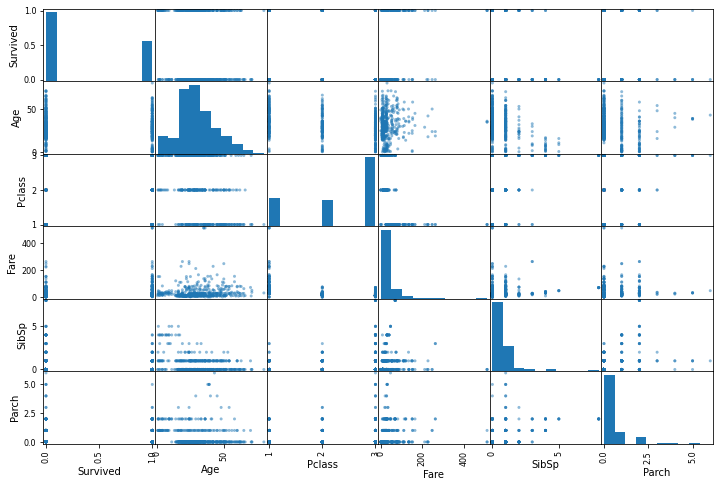

In [81]:
attributes = ['Survived', 'Age', 'Pclass', 'Fare', 'SibSp', 'Parch']
scatter_matrix(uncleaned_training_set[attributes], figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1222d4c10>,
      dtype=object)

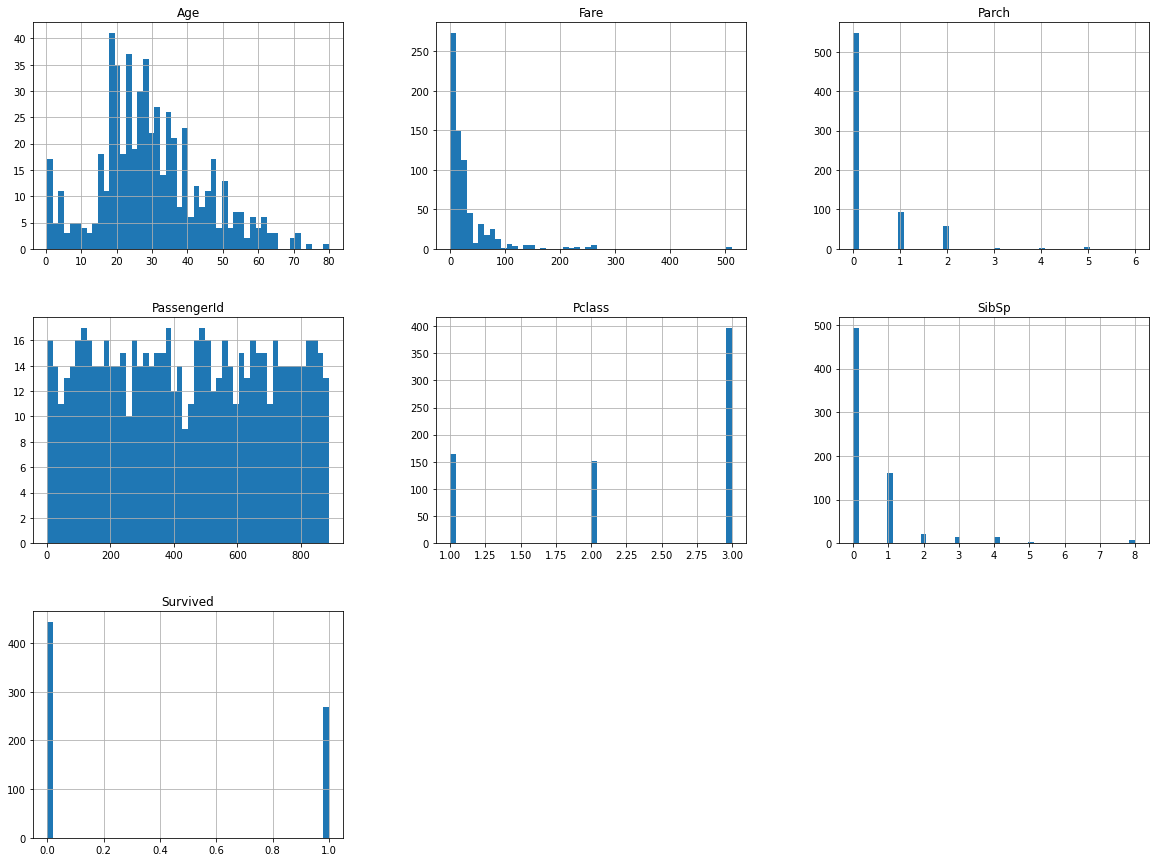

In [6]:
uncleaned_training_set.hist(bins=50, figsize=(20,15)) # plot histograms for each numeric attribute
# plt.show() # don't actually need this command because plots are displayed automatically in Jupyter

### The Feature Set
891 people (in training/validation sets)

1. PassengerId - 0 nulls - int64
    - Unlikely to be helpful
    - Done: Leave this out for now.
2. Pclass - 0 nulls - int64  
    - 1, 2 or 3
    - Done: One-hot-encoded
3. Name - 0 nulls - object
    - Contains honorifics that could be helpful ('Miss.', 'Mrs', 'Mr.', 'Master.', etc)
    - Includes nicknames
    - TODO: Parse out honorifics, and one-hot-encode them
4. Sex - 0 nulls - object 
    - "female" or "male"
    - Done: converted to binary int
5. Age - 177 nulls - float64
    - in years
    - rounded to 1/12s if <1 year
    - rounded to 0.5 or 1.0 if >1 year
    - Done: Handle nulls - use median? Then standardize.
6. SibSp - 0 nulls - int64
    - 283 non-zero values, of which most are 1s
    - 21 instances of SibSp >1 for adult passengers
    - Done: Standardized.
7. Parch - 0 nulls - int64 
    - 213 non-zero values
    - Done: Standardized.
8. Ticket - 0 nulls - object 
    - String
    - At a glance, structure seems to depend on class
    - Done: Left out for now
9. Fare - 0 nulls - float64
    - 15 people have a fare of 0
    - Strongly correlated with class, except a few 0 values
    - 3rd class range: 0-69.5500
    - 2nd class range: 0-73.5
    - 1st class range: 0-512.3292
    - Any changes to handle zero values? Zero fare passengers include people in all three classes. Could have been a mistake, or passengers who rode free b/c they worked on the boat, or they won some competition? Try adding ZeroFare column that is just 1 or 0.
    - Done: Standardized. Added a column for HadZeroFare
10. Cabin - 687 nulls - object 
    - Mostly null
    - String when defined
    - Done: Parsed strings and one-hot-encoded letters from them - may correlate with survival b/c some cabin letters may be closer to top deck.
11. Embarked - 2 nulls - object 
    - 'Q', 'S', or 'C'
    - Done: one-hot-encode these. Handled nulls by creating a 'None'
12. Survived - 0 nulls - int64  
    - 0 or 1
    - Target

In [226]:
# Create custom transformer to get cabin letters
class CabinLetterAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        cabin_letters = self.get_all_cabin_letters(X)
        return pd.DataFrame({ 'CabinLetter': cabin_letters }, columns = ['CabinLetter'])
    def get_all_cabin_letters(self, X):
        cabins = X['Cabin']
        cabin_letters = [self.get_cabin_letter(cabin) for cabin in cabins]
        return cabin_letters
    def get_cabin_letter(self, cabin):
        if (cabin is None) or (not isinstance(cabin, str)):
            return None
        match = re.match('.*([A-Z])\d+$', cabin)
        if match is None:
            return None
        return match.groups()[0]

In [235]:
# Create custom transformer to get zero fare
class HadZeroFareAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        fares = X['Fare']
        zero_fares = [(1 if fare == 0 else 0) for fare in fares]
        return pd.DataFrame({ 'HadZeroFare': zero_fares }, columns = ['HadZeroFare'])

In [264]:
class CategoricalConstantImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value=None):
        # could add strategy with most_frequent as an option to more closely match SimpleImputer
        self.fill_value = fill_value
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill_value)
        

In [290]:
# Perform data transformations
nulls_to_median_pipeline = Pipeline([
    ('nulls_to_median_imputer', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler()),
])

nulls_to_zero_pipeline = Pipeline([
    ('nulls_to_zero', SimpleImputer(strategy='constant', fill_value=0)),
    ('standardize', StandardScaler()),
])

one_hot_encode_nulls_pipeline = Pipeline([
    ('fill_nulls', CategoricalConstantImputer(fill_value='Unknown')),
    ('encode', OneHotEncoder()),
])

cabin_pipeline = Pipeline([
    ('add_cabin_letter', CabinLetterAdder()),
    ('fill_nulls', CategoricalConstantImputer(fill_value='Unknown')),
    ('encode_categorical', OneHotEncoder()),
])

pipeline = ColumnTransformer([
    # Custom transformation to add column for people who paid zero fare
    ('add_zero_fare', HadZeroFareAdder(), ['Fare']), # TODO better way to handle Fare?
    ('nulls_to_median', nulls_to_median_pipeline, ['Age', 'Fare']), # TODO better way to handle Fare?
    ('nulls_to_zero', nulls_to_zero_pipeline, ['SibSp', 'Parch']),
    # One-hot-encode categorical columns
    ('encode_categorical', OneHotEncoder(drop='if_binary'), ['Pclass', 'Sex']), # 'Embarked'
    ('encode_categorical_with_nulls', one_hot_encode_nulls_pipeline, ['Embarked']),
    # Custom transformation to get cabin letters
    ('encode_cabin_letter', cabin_pipeline, ['Cabin']),
])

transformed_columns = [
    'HadZeroFare',
    'StandardizedAge',
    'StandardizedFare',
    'StandardizedSibSp',
    'StandardizedParch',
    'Class-1',
    'Class-2',
    'Class-3',
    'IsMale',
    'Embarked-C',
    'Embarked-Q',
    'Embarked-S',
    'Embarked-Unknown',
    'Deck-A',
    'Deck-B',
    'Deck-C',
    'Deck-D',
    'Deck-E',
    'Deck-F',
    'Deck-G',
    'Deck-Unknown',
] 

training_data = pipeline.fit_transform(uncleaned_training_set)
training_set = pd.DataFrame(training_data, columns = transformed_columns)
training_labels = uncleaned_training_set['Survived']

pd.DataFrame(training_set, columns = transformed_columns).head()

,HadZeroFare,StandardizedAge,StandardizedFare,StandardizedSibSp,StandardizedParch,Class-1,Class-2,Class-3,IsMale,Embarked-C,...,Embarked-S,Embarked-Unknown,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-Unknown
0,0.0,-2.091633,0.004441,2.980762,2.065752,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,-0.132335,-0.477689,-0.474350,-0.454926,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-0.367451,-0.023835,0.389428,0.805413,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,-1.621402,-0.311177,0.389428,0.805413,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.416268,9.805500,-0.474350,-0.454926,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Notes on multicolinearity
If we had no nulls, we could leave out the column Embarked_C because it could be derived from columns Embarked_Q and Embarked_S. If Embarked_Q = 0 and Embarked_S = 0, then we know Embarked_C = 1. If we include a column for Embarked_C, then we will have linearly dependent columns, and there would be infinitely many sets of weight values that would give exactly the same prediction probabilities. This is called multicollinearity, and it can make the model weights less interpretable.

#### Example
If survival was 100% from Q and S, and 0% from C, the following model parameters (bias b and weights w<sub>Q</sub>, w<sub>S</sub>, and w<sub>C</sub>) would result in the same prediction probabilities:
- w<sub>Q</sub> = 1, w<sub>S</sub> = 1, w<sub>C</sub> = 0, b = 0
    - Embarked_Q = 1 => w<sub>Q</sub>(Embarked_Q) + w<sub>S</sub>(Embarked_S) + w<sub>C</sub>(Embarked_C) + b = 1
    - Embarked_S = 1 => w<sub>Q</sub>(Embarked_Q) + w<sub>S</sub>(Embarked_S) + w<sub>C</sub>(Embarked_C) + b = 1
    - Embarked_C = 1 => w<sub>Q</sub>(Embarked_Q) + w<sub>S</sub>(Embarked_S) + w<sub>C</sub>(Embarked_C) + b = 0
- w<sub>Q</sub> = 0, w<sub>S</sub> = 0, w<sub>C</sub> = -1, b = 1
    - Embarked_Q = 1 => w<sub>Q</sub>(Embarked_Q) + w<sub>S</sub>(Embarked_S) + w<sub>C</sub>(Embarked_C) + b = 1
    - Embarked_S = 1 => w<sub>Q</sub>(Embarked_Q) + w<sub>S</sub>(Embarked_S) + w<sub>C</sub>(Embarked_C) + b = 1
    - Embarked_C = 1 => w<sub>Q</sub>(Embarked_Q) + w<sub>S</sub>(Embarked_S) + w<sub>C</sub>(Embarked_C) + b = 0

In [163]:
"""# check to make sure all cells have integer values
check_data_set = training_set

columns = list(check_data_set.columns)
missing_data = False

for column in columns:
    column_data = check_data_set[column].tolist()
    if any((np.isnan(elem) or not isinstance(elem, int)) for elem in column_data):
        missing_data = True
        
missing_data"""

'# check to make sure all cells have integer values\ncheck_data_set = training_set\n\ncolumns = list(check_data_set.columns)\nmissing_data = False\n\nfor column in columns:\n    column_data = check_data_set[column].tolist()\n    if any((np.isnan(elem) or not isinstance(elem, int)) for elem in column_data):\n        missing_data = True\n        \nmissing_data'

In [338]:
def display_scores(model, cv_scores, training_labels, training_predictions):
    print('----------- ', 'Model type:', type(model).__name__, ' ----------')
    
    print('Cross Val - Scores:', cv_scores)
    print('Cross Val - Mean:', cv_scores.mean())
    print('Cross Val - Standard Deviation:', cv_scores.std())
    print(' ')
    print('Training  - Accuracy:', accuracy_score(training_labels, training_predictions))
    print('Training  - Log Loss:', log_loss(training_labels, training_predictions))
    print('Training  - F1 Score:', f1_score(training_labels, training_predictions))
    print('Training  - Confusion Matrix:')
    print(confusion_matrix(training_labels, training_predictions))
    print(' ')
    print('Training  - Precision (percent of survival predictions that actually survived):')
    print(precision_score(training_labels, training_predictions))
    print(' ')
    print('Training  - Recall (percent of survivers that were predicted to survive):')
    print(recall_score(training_labels, training_predictions))
    print(' ')

def predict(model, training_set, training_labels):
    model.fit(training_set, training_labels)
    training_predictions = model.predict(training_set)
    cv_neg_log_loss_scores = cross_val_score(model, training_set, training_labels, scoring='neg_log_loss', cv=10) # scoring='f1',
    cv_log_loss_scores = -cv_neg_log_loss_scores
    display_scores(model, cv_log_loss_scores, training_labels, training_predictions)
    

In [339]:
print('----------- ', 'Baseline, only looking at gender', ' ----------')
random_forest_model = RandomForestClassifier(random_state=0)
predict(random_forest_model, training_set[['IsMale']], training_labels)

print('========================================')

logistic_regression_model = LogisticRegression(random_state=0)
predict(logistic_regression_model, training_set, training_labels)

# Random Forest is overfitting severely
random_forest_model = RandomForestClassifier(random_state=0)
predict(random_forest_model, training_set, training_labels)

-----------  Baseline, only looking at gender  ----------
-----------  Model type: RandomForestClassifier  ----------
Cross Val - Scores: [0.57800323 0.47120708 0.59237087 0.50482775 0.46195004 0.52832378
 0.40640964 0.52846121 0.46958498 0.54853533]
Cross Val - Mean: 0.5089673917746022
Cross Val - Standard Deviation: 0.05455736760988734
 
Training  - Accuracy: 0.7907303370786517
Training  - Log Loss: 7.227992213865287
Training  - F1 Score: 0.7072691552062867
Training  - Confusion Matrix:
[[383  66]
 [ 83 180]]
 
Training  - Precision (percent of survival predictions that actually survived):
0.7317073170731707
 
Training  - Recall (percent of survivers that were predicted to survive):
0.6844106463878327
 
-----------  Model type: LogisticRegression  ----------
Cross Val - Scores: [0.49989294 0.47219371 0.46176465 0.43649964 0.43793929 0.4002044
 0.41629356 0.4123678  0.39588649 0.44907007]
Cross Val - Mean: 0.4382112544223946
Cross Val - Standard Deviation: 0.03165326731233293
 
Traini

In [ ]:
# logistic_regression_model.coef_ # weights = [-0.89414006,  2.62642792, -0.20833906, -0.03170161, -0.17377863, -0.48691802]
# These weights show that the passenger's sex is the main determinant of the model's survival prediction